In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import sys
sys.path.append('../')
from utils import visualize_data_sample
from sklearn.utils import shuffle
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy
from sklearn.model_selection import train_test_split


In [2]:
x_data = np.load('../datasets/tp4/pipeline_images.npy')
y_data = np.load('../datasets/tp4/pipeline_predections.npy')

In [3]:
print(f'x_data shape : {x_data.shape}')
print(f'y_data shape : {y_data.shape}')

x_data shape : (1112, 228, 308, 3)
y_data shape : (1112, 4)


In [4]:
def preprocess(x_data):
    gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_data])
    gray_images = gray_images.astype('float32') / 255.0
    gray_images = np.expand_dims(gray_images, -1)
    
    return gray_images

In [5]:
x_data = preprocess(x_data)

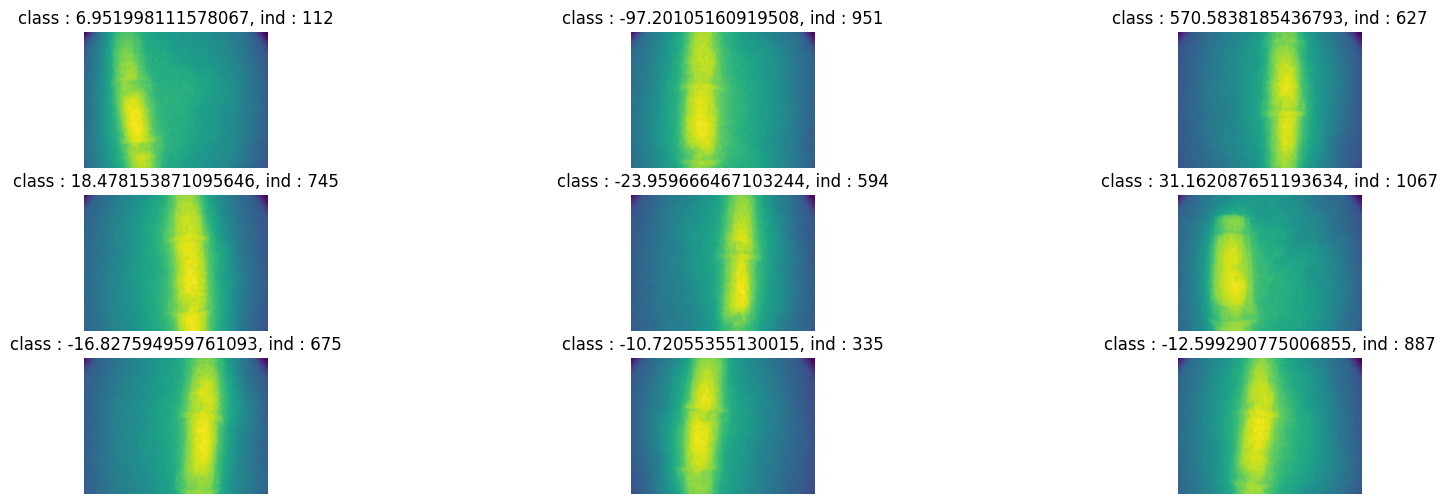

In [6]:
visualize_data_sample(x=x_data, y=y_data[:, 0], random=True)

In [7]:
y_data = y_data[:, 0:2]
y_data[:, 0] = np.abs(y_data[:, 0])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, shuffle=True)

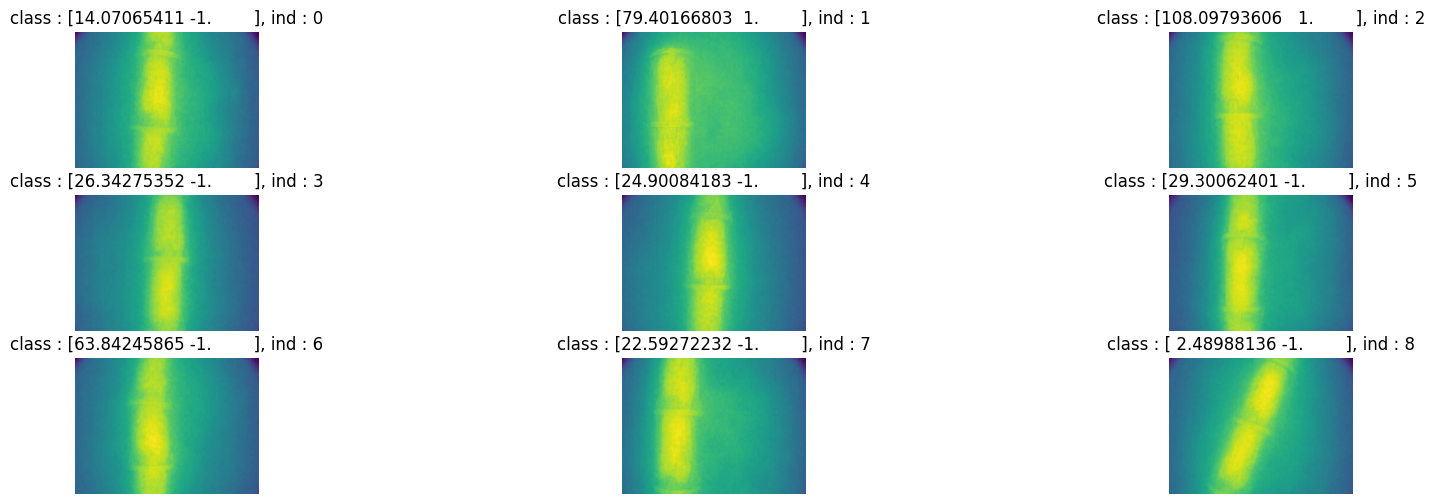

In [15]:
visualize_data_sample(x_train, y_train, random=False)

In [16]:
def print_angle_value(tan):
    print(f'rad value : {math.atan(tan)}')
    print(f'deg value : {math.degrees(math.atan(tan))}')

In [17]:
input = Input((228, 308, 1))

x = Conv2D(filters=8, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

out1 = Dense(1, name='regression_angle')(x)
out2 = Dense(1, activation='sigmoid', name='classification_sign')(x)


model = Model(inputs=input, outputs=[out1, out2])

TypeError: got an unexpected keyword argument 'name'

In [40]:
model.summary()
opt = Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss={'regression_angle': 'mse', 'classification_sign': binary_crossentropy},
    metrics={'regression_angle': 'mse', 'classification_sign': 'accuracy'}
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 308,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 226, 306,  │         80 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 226, 306,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 226, 306,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 113, 153,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 76,    │      1,168 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 76,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 56, 76,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 38,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 17024)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    272,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         17 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 273,842 (1.04 MB)

 Trainable params: 273,762 (1.04 MB)

 Non-trainable params: 80 (320.00 B)

In [41]:
model.fit(x_train, [y_train[:, 0], y_train[:, 1]], batch_size=16, epochs=15)

Epoch 1/15


KeyError: "There are keys: ['classification_sign', 'regression_angle'] in the `loss` argument, but they can't be found in the model's output (`y_pred`)."

In [34]:
print(y_train_sign)

[[0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
